<a href="https://colab.research.google.com/github/KTH-EXPECA/summer-school-2025/blob/main/part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install scipy

Download the datasets:

In [4]:
!mkdir -p /content/data
!curl -L -o /content/data/dataset.zip "https://github.com/KTH-EXPECA/summer-school-2025/raw/refs/heads/main/dataset.zip"
!unzip -q -o /content/data/dataset.zip
!rm -rf /content/data
!rm -rf /content/__MACOSX

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 20.5M  100 20.5M    0     0  12.6M      0  0:00:01  0:00:01 --:--:-- 40.8M


Import required packages:

In [5]:
import pickle, json
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [6]:
pkl_path = Path("/content/dataset.pkl")
with open(pkl_path, "rb") as f:
    datasets = pickle.load(f)

for i, item in enumerate(datasets, 1):
    df = pd.DataFrame(item.get("dataset"))
    meta = {k: v for k, v in item.items() if k != "dataset"}

    print(f"\n===== ITEM {i} =====")
    print("META:", meta)
    print(f"DATASET: DataFrame shape={df.shape}, columns:{df.columns}")


===== ITEM 1 =====
META: {'db_id': 0, 'dataset_name': 'e20', 'stream_rnti': '77e2', 'size': 90306, 'arrivals_num': 18061}
DATASET: DataFrame shape=(90306, 13), columns:Index(['segment', 'packet_id', 'timestamp', 'depart_timestamp', 'slot', 'len',
       'mcs_index', 'mretx', 'rfailed', 'num_rbs', 'num_symbols',
       'time_since_start', 'time_since_last_event'],
      dtype='object')

===== ITEM 2 =====
META: {'db_id': 1, 'dataset_name': 'e4', 'stream_rnti': 'a431', 'size': 146421, 'arrivals_num': 36602}
DATASET: DataFrame shape=(146421, 13), columns:Index(['segment', 'packet_id', 'timestamp', 'depart_timestamp', 'slot', 'len',
       'mcs_index', 'mretx', 'rfailed', 'num_rbs', 'num_symbols',
       'time_since_start', 'time_since_last_event'],
      dtype='object')

===== ITEM 3 =====
META: {'db_id': 2, 'dataset_name': 'e19', 'stream_rnti': '37ff', 'size': 89016, 'arrivals_num': 18058}
DATASET: DataFrame shape=(89016, 13), columns:Index(['segment', 'packet_id', 'timestamp', 'depart_

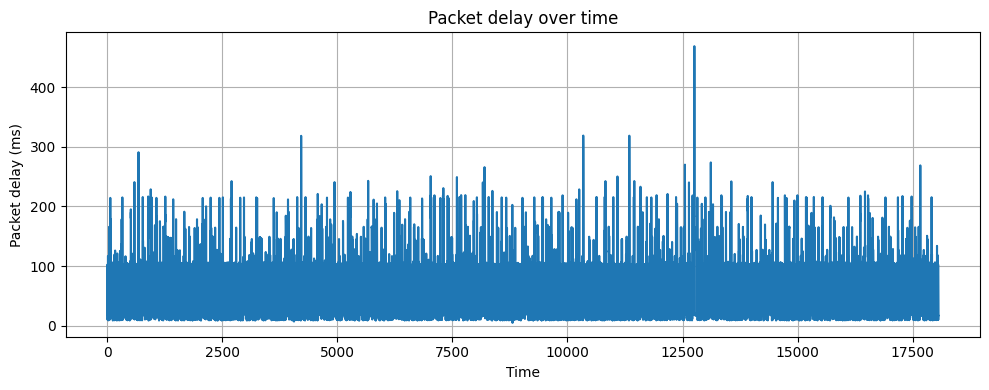

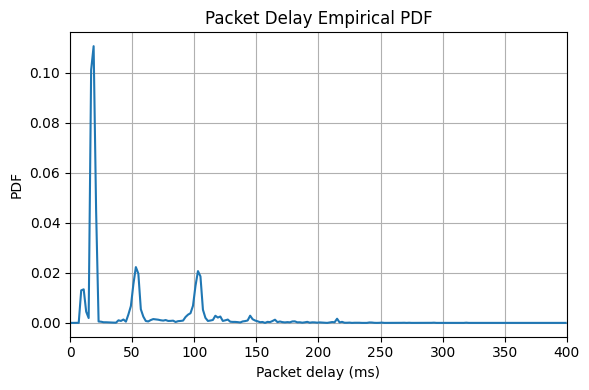

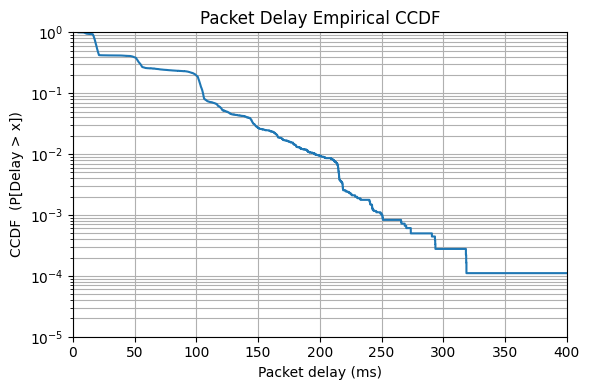

In [7]:
df = pd.DataFrame(datasets[0]['dataset'])
df = df.loc[df['segment'] == -1].copy()

df['packet_delay_ms'] = (df['depart_timestamp'].astype(float) - df['timestamp'].astype(float)) * 1000
packet_delays_ms = df['packet_delay_ms'].tolist()

plt.figure(figsize=(10, 4))
plt.plot(df['packet_delay_ms'].values)
plt.xlabel('Time')
plt.ylabel('Packet delay (ms)')
plt.title('Packet delay over time')
plt.grid(True)
plt.tight_layout()
plt.show()

# Use the same delays column you computed
delays = pd.to_numeric(df['packet_delay_ms'], errors='coerce').dropna().to_numpy()

# Keep only [0, 400] ms for the plot domain
mask = (delays >= 0) & (delays <= 400)
delays_clip = delays[mask]

# Histogram as PDF (area = 1). 2 ms bins across 0–400 ms -> 200 bins
bins = np.linspace(0, 400, 201)
pdf_vals, bin_edges = np.histogram(delays_clip, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(6, 4))
plt.plot(bin_centers, pdf_vals)
plt.xlim(0, 400)
plt.xlabel('Packet delay (ms)')
plt.ylabel('PDF')
plt.title('Packet Delay Empirical PDF')
plt.grid(True)
plt.tight_layout()
plt.show()

# calculate CCDF
delays = pd.to_numeric(df['packet_delay_ms'], errors='coerce').dropna().to_numpy()
delays.sort()                              # ascending
n = delays.size
ccdf = 1.0 - (np.arange(1, n + 1) / n)     # empirical CCDF = 1 - ECDF

# plot CCDF
plt.figure(figsize=(6, 4))
plt.step(delays, ccdf, where='post')       # survival curve style
plt.yscale('log')
plt.xlim(0, 400)
plt.ylim(1e-5, 1)
plt.xlabel('Packet delay (ms)')
plt.ylabel('CCDF  (P[Delay > x])')
plt.title('Packet Delay Empirical CCDF')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()




In [8]:
!pip install tensorflow
!pip install keras

In [58]:
import h5py
import keras
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

from typing import Tuple

import keras
import numpy as np
import numpy.typing as npt
import tensorflow as tf
from keras import layers

from keras.saving import register_keras_serializable

@register_keras_serializable(package="custom")
def bounded_tanh(x, lo=-0.1, hi=2.0):
    return lo + (hi - lo) * (tf.math.tanh(x) + 1.) / 2.

def create_model_inputs(feature_names, dtype=tf.float32):
    inputs = {}
    for feature_name in feature_names:
        inputs[feature_name] = layers.Input(
            name=feature_name,
            shape=(1,),
            dtype=dtype,
        )
    return inputs

def squeeze_generic(a, axes_to_keep):
    out_s = [s for i, s in enumerate(a.shape) if i in axes_to_keep or s != 1]
    return a.reshape(out_s)

class MLP:
    def __init__(
        self,
        bayesian,
        batch_size,
        feature_names: list,  # list(str)
        name: str = "mlp",
        output_layer_config: dict = None,
        dtype=tf.dtypes.float64,
        hidden_sizes=(16, 16),
        hidden_activation="tanh",
        kernel_initializer="glorot_uniform",
        bias_initializer="glorot_uniform",  # 'zeros'
        dropout_ph=None,
        loaded_mlp_model: keras.Model = None,
    ):
        """
        :param dropout_ph: None if no dropout should be used. Else a scalar placeholder that determines the prob of dropping a node.
        Remember to set placeholder to Zero during test / eval
        """

        if loaded_mlp_model is not None:
            # set the model
            self._model = loaded_mlp_model

            # find the input layer and slices
            self._input_layer = self._model.get_layer("input")
            # find slice layer names
            slice_names = []
            int_node = self._input_layer._inbound_nodes[0]

            # figure out inbound_layers size
            tmp = np.array([int_node.inbound_layers])
            tmp = np.transpose(tmp)
            tmp = squeeze_generic(tmp, [0])
            if len(tmp) > 1:
                # more than one input layer
                for idx, layer in enumerate(int_node.inbound_layers):
                    slice_names.append(layer.name)
            else:
                # only one input layer
                slice_names.append(int_node.inbound_layers.name)

            # create input slices by concatenating slices
            self._input_slices = {}
            for slice_name in slice_names:
                self._input_slices[slice_name] = self._model.get_layer(slice_name).input

            # find the output layer and slices
            self._output_layer = self._model.get_layer("output")
            # find slice layer names
            slice_names = []
            int_node = self._output_layer._inbound_nodes[0]
            for idx, layer in enumerate(int_node.inbound_layers):
                slice_names.append(layer.name)
            # create output layer by concatenating slices
            self._output_slices = {}
            for slice_name in slice_names:
                self._output_slices[slice_name] = self._model.get_layer(
                    slice_name
                ).output

        else:

            # Using functional API of keras instead of sequential
            self._input_slices = create_model_inputs(feature_names,dtype=dtype)
            if len(feature_names) == 1:
                self._input_layer = layers.Dense(
                    1, activation=None, use_bias=False, name="input"
                )(list(self._input_slices.values())[0])
            else:
                self._input_layer = keras.layers.concatenate(
                    list(self._input_slices.values()), name="input"
                )

            # features = layers.BatchNormalization()(features)

            for idx, hidden_size in enumerate(hidden_sizes):
                if idx == 0:
                    prev_layer = self._input_layer

                # create the new hidden layer
                hidden_layer = layers.Dense(
                    name="hidden_%d" % idx,
                    units=hidden_size,
                    activation=hidden_activation,
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,
                    dtype=dtype,
                )

                # connect the new layer
                prev_layer = hidden_layer(prev_layer)

                # create and connect the dropout layer
                if dropout_ph is not None:
                    dropout_layer = layers.Dropout(dropout_ph)
                    prev_layer = dropout_layer(prev_layer)

            # create output layer by concatenating slices
            self._output_slices = {}
            slices = []
            for slice_name in output_layer_config:
                slice_dense = layers.Dense(
                    name=slice_name,
                    units=output_layer_config[slice_name]["slice_size"],
                    activation=output_layer_config[slice_name]["slice_activation"],
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,
                    dtype=dtype,
                )
                self._output_slices[slice_name] = slice_dense(prev_layer)
                slices.append(self._output_slices[slice_name])

            # connect output layer
            self._output_layer = layers.Concatenate(name="output")(slices)
            # print(self._output_layer)

            # create model
            self._model = keras.Model(
                inputs=self._input_slices, outputs=self._output_layer, name=name
            )
            # self._model.summary()

    @property
    def input_layer(self):
        return self._input_layer

    @property
    def input_slices(self):
        return self._input_slices

    @property
    def output_slices(self):
        return self._output_slices

    @property
    def model(self):
        return self._model


# Single Layer Perceptron
class SLP:
    def __init__(
        self,
        bayesian,
        batch_size,
        name: str = "slp",
        layer_config: dict = None,
        dtype=tf.dtypes.float64,
        kernel_initializer="glorot_uniform",
        bias_initializer="glorot_uniform",  # 'zeros' VERY IMPORTANT! Otherwise all components would be the same
        loaded_slp_model: keras.Model = None,
    ):
        """
        Remember to set placeholder to Zero during test / eval
        """

        if loaded_slp_model is not None:
            # set the model
            self._model = loaded_slp_model

            # find the input and output layers
            self._input_layer = self._model.input
            self._output_layer = self._model.get_layer("output")

            # find slice layer names
            slice_names = []
            int_node = self._output_layer._inbound_nodes[0]
            for idx, layer in enumerate(int_node.inbound_layers):
                slice_names.append(layer.name)

            # create output layer by concatenating slices
            self._output_slices = {}
            for slice_name in slice_names:
                self._output_slices[slice_name] = self._model.get_layer(
                    slice_name
                ).output

        else:

            # Using functional API of keras

            # This is just a dummy input
            self._input_layer = keras.Input(
                name="dummy_input",
                shape=(1,), # Changed from shape=(1) to shape=(1,)
                batch_size=batch_size,
                dtype=dtype,
            )

            # create the single layer by concatenating slices
            self._output_slices = {}
            slices = []
            for slice_name in layer_config:
                slice_dense = layers.Dense(
                    name=slice_name,
                    units=layer_config[slice_name]["slice_size"],
                    activation=layer_config[slice_name]["slice_activation"],
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,
                    dtype=dtype,
                )
                self._output_slices[slice_name] = slice_dense(self._input_layer)
                slices.append(self._output_slices[slice_name])

            # connect output layer
            self._output_layer = layers.Concatenate(name="output")(slices)
            # print(self._output_layer)

            # create model
            self._model = keras.Model(
                inputs=self._input_layer, outputs=self._output_layer, name=name
            )
            # self._model.summary()

    @property
    def input_layer(self):
        return self._input_layer

    @property
    def output_slices(self):
        return self._output_slices

    @property
    def model(self):
        return self._model



class DensityEstimator:
    def __init__(
        self,
        h5_addr: str = None,
        bayesian: bool = False,
        batch_size: int = None,
        dtype: str = "float64",
    ):
        self._bayesian = bayesian
        self._batch_size = batch_size

        # configure keras to use dtype
        tf.keras.backend.set_floatx(dtype)

        # for creating the tensors
        if dtype == "float64":
            self._dtype = tf.float64
        elif dtype == "float32":
            self._dtype = tf.float32
        elif dtype == "float16":
            self._dtype = tf.float16
        else:
            raise Exception("unknown dtype format")

    def create_core(self, h5_addr: str):
        pass

    def save(self, h5_addr: str):
        pass

    def create_models(self):
        pass

    def prob_single(self):
        pass

    def prob_batch(self):
        pass

    def sample_n(self):
        pass

    def get_parameters(self):
        pass

    def fit(self):
        pass

    @property
    def prob_pred_model(self) -> keras.Model:
        return self._prob_pred_model

    @property
    def sample_model(self) -> keras.Model:
        return self._sample_model

    @property
    def params_model(self) -> keras.Model:
        return self._params_model

    @property
    def training_model(self) -> keras.Model:
        return self._training_model

    @property
    def pl_training_model(self) -> keras.Model:
        return self._pl_training_model

    @property
    def params_config(self) -> dict:
        return self._params_config

    @property
    def core_model(self):
        return self._core_model

    @property
    def loss(self):
        return self._loss

    @property
    def bayesian(self):
        return self._bayesian

    @property
    def batch_size(self):
        return self._batch_size

    @property
    def dtype(self):
        return self._dtype


class NonConditionalDensityEstimator(DensityEstimator):
    def create_core(self, h5_addr: str):

        # initiate the slp model
        if h5_addr is not None:
            # load the keras model and feed to SLP
            self._core_model = SLP(
                loaded_slp_model=keras.models.load_model(
                    h5_addr,
                ),
                bayesian=self.bayesian,
                batch_size=self.batch_size,
            )

        else:
            # create SLP model
            self._core_model = SLP(
                name="slp_keras_model",
                bayesian=self.bayesian,
                batch_size=self.batch_size,
                layer_config=self.params_config,
                dtype=self.dtype,
            )

    def prob_single(self, y: np.float64) -> Tuple[np.float64, np.float64, np.float64]:

        # for single value x (not batch)
        # y : np.float64 number
        x = 0
        [pdf, log_pdf, ecdf] = self.prob_pred_model.predict(
            [np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)],
        )
        return np.squeeze(pdf), np.squeeze(log_pdf), np.squeeze(ecdf)

    def prob_batch(
        self,
        y: npt.NDArray[np.float64],
        batch_size=32,
        verbose=0,
        steps=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False,
    ):

        # for large batches of input y
        # y : np.array of np.float64 with the shape (batch_size,1) e.g. np.array([5,6,7,8,9,10])
        x = np.zeros(len(y))

        # IMPORTANT: batch size by default in keras is set to 32, if data length is 32*k+1, it raises error.
        if len(y) > batch_size:
            if len(y) % batch_size == 1:
                batch_size = batch_size * 2

        [pdf, log_pdf, ecdf] = self.prob_pred_model.predict(
            [x, y],
            batch_size=len(y),
            verbose=verbose,
            steps=steps,
            callbacks=None,
            max_queue_size=max_queue_size,
            workers=workers,
            use_multiprocessing=use_multiprocessing,
        )
        return np.squeeze(pdf), np.squeeze(log_pdf), np.squeeze(ecdf)

    def sample_n(
        self,
        n: int,
        random_generator: np.random.Generator = np.random.default_rng(),
        batch_size=None,
        verbose=0,
        steps=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False,
    ) -> npt.NDArray[np.float64]:

        # generate n random numbers uniformly distributed on [0,1]
        x = np.zeros(n)
        y = random_generator.uniform(0, 1, n)

        samples = self.sample_model.predict(
            [x, y],
            batch_size=batch_size,
            verbose=verbose,
            steps=steps,
            callbacks=None,
            max_queue_size=max_queue_size,
            workers=workers,
            use_multiprocessing=use_multiprocessing,
        )
        return np.squeeze(samples)

    def get_parameters(self) -> dict:

        # for single value x (not batch)
        # y : np.float64 number
        x = 0
        # for single value x (not batch)
        # x : np.array of np.float64 with the shape (ndim)
        prediction_res = self.params_model.predict(np.expand_dims(x, axis=0))

        result_dict = {}
        for idx, param in enumerate(self.params_config):
            result_dict[param] = np.squeeze(prediction_res[idx])

        return result_dict

    def fit(
        self,
        Y,
        optimizer,
        batch_size: int = 1000,
        epochs: int = 10,
    ):

        # this keras model is the one that we use for training
        # self.core_model.model.compile(optimizer=optimizer, loss=self.loss)
        self.training_model.compile(optimizer=optimizer, loss=self.loss)

        X = np.zeros(len(Y))
        # history = self.core_model.model.fit(
        self.training_model.fit(
            x=[X, Y],
            y=Y,
            batch_size=batch_size,
            epochs=epochs,
            # We pass some validation for
            # monitoring validation loss and metrics
            # at the end of each epoch
            # validation_data=(x_val, y_val),
        )

    def fit_pipeline(
        self,
        train_dataset,
        test_dataset,
        optimizer,
        batch_size: int = 1000,
        epochs: int = 10,
    ):

        # this keras model is the one that we use for training
        # self.core_model.model.compile(optimizer=optimizer, loss=self.loss)
        self.pl_training_model.compile(optimizer=optimizer, loss=self.loss)

        # In this train_dataset, there must be an all zero column

        # history = self.core_model.model.fit(
        self.pl_training_model.fit(
            train_dataset,
            batch_size=batch_size,
            epochs=epochs,
            # We pass some validation for
            # monitoring validation loss and metrics
            # at the end of each epoch
            validation_data=test_dataset,
            # metrics=[keras.metrics.KLDivergence()]
        )



class GaussianMM(NonConditionalDensityEstimator):
    def __init__(
        self,
        centers: int = 8,
        h5_addr: str = None,
        batch_size: int = None,
        dtype: str = "float64",
    ):

        super(GaussianMM, self).__init__(
            h5_addr=h5_addr,
            batch_size=batch_size,
            dtype=dtype,
        )

        # figure out parameters
        if h5_addr is not None:
            # read side parameters
            with h5py.File(h5_addr, "r") as hf:
                self._centers = int(hf.get("centers")[0])

                if "y_mean" in hf and "y_std" in hf:
                    self._y_mean = float(hf["y_mean"][0])
                    self._y_std  = float(hf["y_std"][0])

                if "batch_size" in hf.keys():
                    self._batch_size = int(hf.get("batch_size")[0])

        else:
            self._centers = centers
            self._batch_size = batch_size

        # create parameters dict
        self._params_config = {
            "mixture_weights": {
                "slice_size": self.centers,
                "slice_activation": "softmax",
            },
            "mixture_locations": {
                "slice_size": self.centers,
                "slice_activation": None,
            },
            "mixture_scales": {
                "slice_size": self.centers,
                "slice_activation": "softplus",
            },
        }

        # ask NonConditionalDensityEstimator to form the SLP
        self.create_core(h5_addr=h5_addr)
        # self._core_model.model.summary()

        # create models for inference:
        # self._prob_pred_model, self._sample_model, self._params_model, self._training_model
        self.create_models()

    def save(self, h5_addr: str) -> None:
        self.core_model.model.save(h5_addr)
        with h5py.File(h5_addr, "a") as hf:
            hf.create_dataset("y_mean", data=np.array([y_mean], dtype=np.float64))
            hf.create_dataset("y_std",  data=np.array([y_std],  dtype=np.float64))
            hf.create_dataset("centers", shape=(1,), data=int(self.centers))
            if self.batch_size is not None:
                hf.create_dataset("batch_size", shape=(1,), data=int(self.batch_size))

    def create_models(self):
        # --- inputs & params ---
        self.dummy_input = self.core_model.input_layer  # shape (None,1)
        self.weights = self.core_model.output_slices["mixture_weights"]  # (None, C)
        self.locs    = self.core_model.output_slices["mixture_locations"]  # (None, C)
        self.scales  = self.core_model.output_slices["mixture_scales"]     # (None, C)

        # params model (unchanged)
        self._params_model = keras.Model(
            inputs=self.dummy_input,
            outputs=[self.weights, self.locs, self.scales],
            name="params_model",
        )

        # y input: use tuple shape
        self.y_input = keras.Input(
            name="y_input",
            shape=(1,),                    # <-- FIX: (1,)
            batch_size=self.batch_size,
            dtype=self.dtype,
        )
        # flatten to scalar per example for TFP
        y_flat = layers.Lambda(lambda y: tf.squeeze(y, axis=-1), name="y_flat")(self.y_input)

        # Small helper building the distribution inside a Keras Lambda
        def _mk_mix(args):
            w, m, s = args
            mix = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=w),  # dtype defaults to int32 internally
                components_distribution=tfd.Normal(loc=m, scale=s),
            )
            return mix

        # We compute pdf/logpdf/cdf via Lambdas so Keras accepts it
        def _pdf(args):
            w, m, s, y = args
            mix = _mk_mix([w, m, s])
            return mix.prob(y)  # (None,)

        def _logpdf(args):
            w, m, s, y = args
            mix = _mk_mix([w, m, s])
            return mix.log_prob(y)  # (None,)

        def _cdf(args):
            w, m, s, y = args
            mix = _mk_mix([w, m, s])
            return mix.cdf(y)  # (None,)

        pdf     = layers.Lambda(_pdf,    name="pdf")    ([self.weights, self.locs, self.scales, y_flat])
        log_pdf = layers.Lambda(_logpdf, name="log_pdf")([self.weights, self.locs, self.scales, y_flat])
        ecdf    = layers.Lambda(_cdf,    name="ecdf")   ([self.weights, self.locs, self.scales, y_flat])

        # expand dims back to (None,1) like you had
        self.pdf     = layers.Lambda(lambda z: tf.expand_dims(z, -1))(pdf)
        self.log_pdf = layers.Lambda(lambda z: tf.expand_dims(z, -1))(log_pdf)
        self.ecdf    = layers.Lambda(lambda z: tf.expand_dims(z, -1))(ecdf)

        # models you use downstream
        self._prob_pred_model = keras.Model(
            inputs=[self.dummy_input, self.y_input],
            outputs=[self.pdf, self.log_pdf, self.ecdf],
            name="prob_pred_model",
        )

        self._pl_training_model = keras.Model(
            inputs={"dummy_input": self.dummy_input, "y_input": self.y_input},
            outputs=[self.log_pdf],
            name="pl_training_model",
        )

        self._training_model = keras.Model(
            inputs=[self.dummy_input, self.y_input],
            outputs=[self.log_pdf],
            name="training_model",
        )

        # loss: negative mean log-likelihood (keeps your signature)
        class CustomLossLayer(tf.keras.layers.Layer):
            def __init__(self, idtype=tf.float64, **kwargs):
                super().__init__(**kwargs)
                self.idtype = idtype
            def call(self, inputs):
                y_true, y_pred = inputs
                # y_pred is (batch,1); take mean over batch
                return -tf.reduce_mean(y_pred)

        self._loss = lambda y_true, y_pred: CustomLossLayer(self.dtype)([y_true, y_pred])

    @property
    def centers(self):
        return self._centers

In [47]:
model = GaussianMM(centers=16)
batch_size = 32

X = None
Y = np.asarray(delays, dtype=np.float64).reshape(-1, 1)
y_mean = float(Y.mean())
y_std  = float(Y.std() + 1e-8)   # avoid divide-by-zero
Yz = (Y - y_mean) / y_std

training_rounds = [
    {"learning_rate": 0.001, "epochs": 64},
    {"learning_rate": 0.0005, "epochs": 64}
]

# Ensure shapes are (N,1)
Xz = np.zeros((len(Yz), 1))
Yz = np.asarray(Yz).reshape(-1, 1)

# pick a number of training samples
n_samples = 500
idx = np.random.choice(len(Yz), size=n_samples, replace=False)

X_sub = Xz[idx]
Y_sub = Yz[idx]

for i, rp in enumerate(training_rounds, 1):
    print(f"Training session {i}/{len(training_rounds)} with {rp}")
    model.training_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=rp["learning_rate"]),
        loss=model.loss,
    )
    model.training_model.fit(
        x=[X_sub, Y_sub],
        y=Y_sub,
        batch_size=batch_size,   # <— use this, not steps_per_epoch
        epochs=rp["epochs"],
        verbose=1,               # <— see logs
        shuffle=True,
    )



Training session 1/2 with {'learning_rate': 0.001, 'epochs': 64}
Epoch 1/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.3643
Epoch 2/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3880 
Epoch 3/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4572 
Epoch 4/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4640 
Epoch 5/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4139 
Epoch 6/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4418
Epoch 7/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3405
Epoch 8/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3574
Epoch 9/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4196  
Epoch 10/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3386 
Epoch 11/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3972 
Epoch 12/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3163 
Epoch 13/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3717 
Epoch 14/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3054 
Epoch 15/

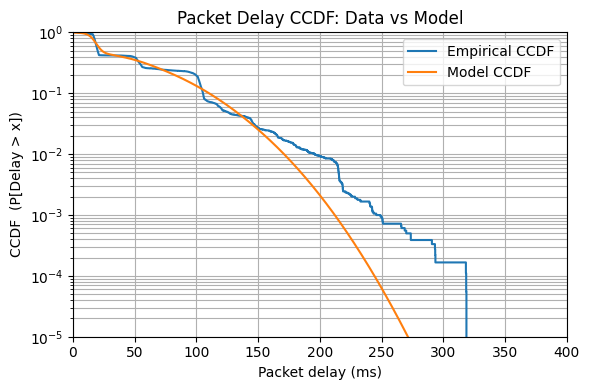

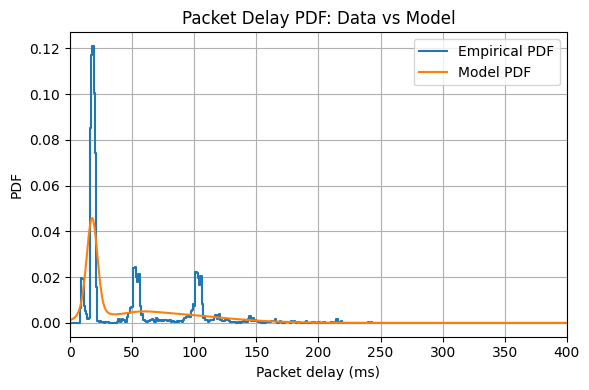

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_ccdf_pdf_with_model(
    delays_ms: np.ndarray,
    model,
    max_x: float = 400.0,
    num_points: int = 1200,
    batch_size: int = 2048,
    y_mean: float | None = None,
    y_std: float | None = None,
    pdf_bins: int = 400,
    use_kde: bool = False,
):
    """
    delays_ms : 1D array of delays (ms)
    model     : your GaussianMM instance (with .prob_pred_model)
    y_mean,y_std : if you trained on standardized targets, pass them here
    """

    # ----- Clean & sort data -----
    delays = pd.to_numeric(pd.Series(delays_ms), errors='coerce').dropna().to_numpy(float)
    delays = delays[(delays >= 0) & (delays <= max_x)]
    delays.sort()
    n = delays.size
    if n == 0:
        raise ValueError("No valid delay samples in range.")

    # ----- Empirical CCDF -----
    emp_ccdf = 1.0 - (np.arange(1, n + 1) / n)

    # ----- Grid for model curves -----
    grid_y = np.linspace(0.0, max_x, num_points)

    # If trained on z, feed z into the model
    if (y_mean is not None) and (y_std is not None):
        z = (grid_y - y_mean) / (y_std + 1e-12)
        jac = 1.0 / (y_std + 1e-12)  # for PDF only
    else:
        z = grid_y
        jac = 1.0

    # dtype & shapes for model inputs
    try:
        dtype_np = getattr(model, "dtype").as_numpy_dtype
    except Exception:
        dtype_np = np.float64

    X_dummy = np.zeros_like(z, dtype=dtype_np).reshape(-1, 1)
    Y_in    = np.asarray(z, dtype=dtype_np).reshape(-1, 1)

    # Predict model pdf/logpdf/ecdf
    pdf_m, logpdf_m, ecdf_m = model.prob_pred_model.predict(
        [X_dummy, Y_in], batch_size=batch_size, verbose=0
    )
    pdf_m   = np.squeeze(pdf_m)   * jac         # scale pdf if standardized
    ccdf_m  = 1.0 - np.squeeze(ecdf_m)         # ccdf unaffected by affine scale

    # ----- Empirical PDF (KDE or histogram density) -----
    # Try KDE for smooth curve; fallback to histogram
    emp_x_pdf = None
    emp_pdf   = None
    if use_kde:
        try:
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(delays)
            emp_x_pdf = grid_y
            emp_pdf   = kde(emp_x_pdf)
        except Exception:
            pass

    if emp_pdf is None:
        # Histogram density estimate
        counts, edges = np.histogram(delays, bins=pdf_bins, range=(0, max_x), density=True)
        emp_x_pdf = 0.5 * (edges[:-1] + edges[1:])
        emp_pdf   = counts

    # ===================== PLOTS =====================

    # CCDF
    plt.figure(figsize=(6, 4))
    plt.step(delays, emp_ccdf, where='post', label='Empirical CCDF')
    plt.plot(grid_y, ccdf_m, label='Model CCDF')
    plt.yscale('log')
    plt.xlim(0, max_x)
    plt.ylim(1e-5, 1)
    plt.xlabel('Packet delay (ms)')
    plt.ylabel('CCDF  (P[Delay > x])')
    plt.title('Packet Delay CCDF: Data vs Model')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # PDF
    plt.figure(figsize=(6, 4))
    # empirical (step if hist; line if KDE)
    if len(emp_x_pdf) == len(grid_y):
        plt.plot(emp_x_pdf, emp_pdf, label='Empirical PDF')
    else:
        plt.step(emp_x_pdf, emp_pdf, where='mid', label='Empirical PDF')
    # model
    plt.plot(grid_y, pdf_m, label='Model PDF')
    plt.xlim(0, max_x)
    plt.xlabel('Packet delay (ms)')
    plt.ylabel('PDF')
    plt.title('Packet Delay PDF: Data vs Model')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Empirical delays array you already computed
# delays = df['packet_delay_ms'].to_numpy()

# If you trained on raw ms:
#plot_ccdf_pdf_with_model(delays_ms=delays, model=model, max_x=400)

# If you trained on standardized targets:
plot_ccdf_pdf_with_model(delays, model, 400, y_mean=y_mean, y_std=y_std)


In [75]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from keras import layers, ops as kops
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

def safe_log(x, eps=1e-40):
    """log clipped to avoid -inf."""
    return tf.math.log(tf.maximum(x, tf.constant(eps, dtype=x.dtype)))

# ------------------------------------------------------------------
# Helper: safe support check + ξ≈0 (exponential) fallback
# ------------------------------------------------------------------
def _gpd_core(z, xi, scale, norm, dtype):
    """
    Core of the GPD pdf / survival / quantile with full ξ∈ℝ support.
    z        : (y - u) / σ    (non-negative tensor)
    xi       : shape ξ        (can be negative, zero, or positive)
    scale    : σ              (must be >0)
    norm     : “normalising” factor coming from the bulk / tail split
    """
    eps = tf.constant(1e-12, dtype=dtype)
    is_exp = tf.abs(xi) < eps          # ξ≈0 → exponential limit

    # 1 + ξ z  (needed many times)
    one_plus = 1. + xi * z

    # ----------------------------------------------------------------
    # pdf
    # ----------------------------------------------------------------
    pdf_gp  = norm / scale * tf.pow(one_plus, -1. - 1./xi)           # ξ≠0
    pdf_exp = norm / scale * tf.exp(-z)                              # ξ≈0
    pdf     = tf.where(is_exp, pdf_exp, pdf_gp)

    # ----------------------------------------------------------------
    # tail (survival) probability
    # ----------------------------------------------------------------
    sf_gp   = norm * tf.pow(one_plus, -1./xi)                        # ξ≠0
    sf_exp  = norm * tf.exp(-z)                                      # ξ≈0
    sf      = tf.where(is_exp, sf_exp, sf_gp)

    return pdf, sf, one_plus, is_exp


# ------------------------------------------------------------------
# 1)  pdf  (works for any ξ)
# ------------------------------------------------------------------
def gpd_prob(tail_threshold, tail_param, tail_scale, norm_factor,
             y_input, dtype=tf.float64):
    y   = tf.squeeze(y_input)
    u   = tf.squeeze(tail_threshold)
    xi  = tf.squeeze(tail_param)
    σ   = tf.squeeze(tail_scale)
    nrm = tf.squeeze(norm_factor)

    # distance above threshold
    z = tf.maximum(y - u, 0.) / σ

    pdf, _, one_plus, _ = _gpd_core(z, xi, σ, nrm, dtype)

    # enforce support for ξ<0 (upper end-point: u − σ/ξ)
    valid = one_plus > 0.
    return tf.where(valid, pdf, tf.zeros_like(pdf))


# ------------------------------------------------------------------
# 2)  tail (survival) probability  P(Y ≥ y)
# ------------------------------------------------------------------
def gpd_tail_prob(tail_threshold, tail_param, tail_scale, norm_factor,
                  y_input, dtype=tf.float64):
    y   = tf.squeeze(y_input)
    u   = tf.squeeze(tail_threshold)
    xi  = tf.squeeze(tail_param)
    σ   = tf.squeeze(tail_scale)
    nrm = tf.squeeze(norm_factor)

    z = tf.maximum(y - u, 0.) / σ
    _, sf, one_plus, _ = _gpd_core(z, xi, σ, nrm, dtype)

    valid = one_plus > 0.
    return tf.where(valid, sf, tf.zeros_like(sf))


# ------------------------------------------------------------------
# 3)  quantile function  (random_input ~ U(0,1))
# ------------------------------------------------------------------
def gpd_quantile(tail_threshold, tail_param, tail_scale, norm_factor,
                 random_input, dtype=tf.float64):
    u       = tf.squeeze(tail_threshold)
    xi      = tf.squeeze(tail_param)
    σ       = tf.squeeze(tail_scale)
    nrm     = tf.squeeze(norm_factor)
    p       = tf.squeeze(random_input)          # assume already U(0,1)

    eps     = tf.constant(1e-12, dtype=dtype)
    is_exp  = tf.abs(xi) < eps

    # exponential limit
    q_exp = u - σ * safe_log(1. - p / nrm)

    # general ξ≠0 case
    q_gp = u + σ / xi * (tf.pow(1. - p / nrm, -xi) - 1.)

    q = tf.where(is_exp, q_exp, q_gp)

    # clamp to upper end-point when ξ<0  (u − σ/ξ)
    upper = u - σ / tf.where(xi < 0., xi, tf.ones_like(xi))
    q = tf.where((xi < 0.) & (q > upper), upper, q)

    return q

def gpd_log_prob(
    tail_threshold,
    tail_param,
    tail_scale,
    norm_factor,
    y_input,
    dtype=tf.float64,
):
    """
    tensor-based gpd log probability calculation
    """
    # all values are greater than tail_threshold
    return safe_log(
        gpd_prob(
            tail_threshold=tail_threshold,
            tail_param=tail_param,
            tail_scale=tail_scale,
            norm_factor=norm_factor,
            y_input=y_input,
            dtype=dtype,
        ),
    )


def split_bulk_gpd(
    tail_threshold,
    y_input,
    y_batch_size,
    dtype: tf.DType = tf.float64,
):
    # squeez variables
    tail_threshold = tf.squeeze(tail_threshold)
    y_input = tf.squeeze(y_input)

    # gives a tensor, indicating which y_input are greater than tail_threshold
    # greater than threshold is true, else false
    bool_split_tensor = tf.greater(y_input, tail_threshold)  # this is in Boolean

    # find the number of samples in each group
    float_split_tensor = tf.cast(
        bool_split_tensor, dtype=dtype
    )  # convert it to float for multiplication
    tail_samples_count = tf.reduce_sum(float_split_tensor)
    bulk_samples_count = y_batch_size - tail_samples_count

    return bool_split_tensor, tail_samples_count, bulk_samples_count



def split_bulk_gpd_cdf(
    norm_factor,
    random_input,
    dtype: tf.DType = tf.float64,
):

    # squeez variables
    norm_factor = tf.squeeze(norm_factor)
    random_input = tf.squeeze(random_input)

    # gives a tensor, indicating which random_input are greater than norm_factor
    # greater than threshold is true, else false
    bool_split_tensor = tf.greater(random_input, norm_factor)  # this is in Boolean

    return bool_split_tensor


def mixture_tail_prob(
    bool_split_tensor,
    gpd_tail_prob_t,
    bulk_tail_prob_t,
    dtype: tf.DType,
):
    gpd_multiplexer = bool_split_tensor
    bulk_multiplexer = tf.logical_not(bool_split_tensor)

    gpd_multiplexer = tf.cast(
        gpd_multiplexer, dtype=dtype
    )  # convert it to float for multiplication
    bulk_multiplexer = tf.cast(
        bulk_multiplexer, dtype=dtype
    )  # convert it to float for multiplication

    multiplexed_gpd_tail_prob = tf.multiply(gpd_tail_prob_t, gpd_multiplexer)
    multiplexed_bulk_tail_prob = tf.multiply(bulk_tail_prob_t, bulk_multiplexer)

    return tf.add(
        multiplexed_gpd_tail_prob,
        multiplexed_bulk_tail_prob,
    )


def mixture_prob(
    bool_split_tensor,
    gpd_prob_t,
    bulk_prob_t,
    dtype: tf.DType,
):
    gpd_multiplexer = bool_split_tensor
    bulk_multiplexer = tf.logical_not(bool_split_tensor)

    gpd_multiplexer = tf.cast(
        gpd_multiplexer, dtype=dtype
    )  # convert it to float for multiplication
    bulk_multiplexer = tf.cast(
        bulk_multiplexer, dtype=dtype
    )  # convert it to float for multiplication

    multiplexed_gpd_prob = tf.multiply(gpd_prob_t, gpd_multiplexer)
    multiplexed_bulk_prob = tf.multiply(bulk_prob_t, bulk_multiplexer)

    return tf.reduce_sum(
        tf.stack(
            [
                multiplexed_gpd_prob,
                multiplexed_bulk_prob,
            ]
        ),
        axis=0,
    )


def mixture_log_prob(
    bool_split_tensor,
    gpd_prob_t,
    bulk_prob_t,
    dtype: tf.DType,
):

    return safe_log(
        mixture_prob(
            bool_split_tensor=bool_split_tensor,
            gpd_prob_t=gpd_prob_t,
            bulk_prob_t=bulk_prob_t,
            dtype=dtype,
        ),
    )


def mixture_sample(
    cdf_bool_split_t,
    gpd_sample_t,
    bulk_sample_t,
    dtype: tf.DType,
):
    gpd_multiplexer = cdf_bool_split_t
    bulk_multiplexer = tf.logical_not(cdf_bool_split_t)

    gpd_multiplexer = tf.cast(
        gpd_multiplexer, dtype=dtype
    )  # convert it to float (1.00 or 0.00) for multiplication
    bulk_multiplexer = tf.cast(
        bulk_multiplexer, dtype=dtype
    )  # convert it to float (1.00 or 0.00) for multiplication

    multiplexed_gpd_sample = tf.multiply(gpd_sample_t, gpd_multiplexer)
    multiplexed_bulk_sample = tf.multiply(bulk_sample_t, bulk_multiplexer)

    return tf.reduce_sum(
        tf.stack(
            [
                multiplexed_gpd_sample,
                multiplexed_bulk_sample,
            ]
        ),
        axis=0,
    )

from keras.saving import register_keras_serializable

@register_keras_serializable(package="custom")
def bounded_tanh(x, lo=-0.1, hi=2.0):
    return lo + (hi - lo) * (tf.math.tanh(x) + 1.) / 2.

# in order to use tfd.Gamma.quantile
# tf.compat.v1.disable_eager_execution()

from scipy.stats import norm
from scipy.optimize import bisect

def gaussian_mixture_quantile(weights: np.ndarray,
                              locs:    np.ndarray,
                              scales:  np.ndarray,
                              p: float = 0.99,
                              bracket_sigmas: float = 10.0) -> float:
    """
    Returns q such that F(q)=p for a 1-D Gaussian mixture
    defined by weights, locs, scales  (all 1-D arrays of equal length).
    """

    # normalise weights in case they do not sum to 1 exactly
    weights = weights / weights.sum()

    def mix_cdf(x: float) -> float:
        return np.sum(weights * norm.cdf((x - locs) / scales))

    # crude but safe bracket
    lo = locs.min() - bracket_sigmas * scales.max()
    hi = locs.max() + bracket_sigmas * scales.max()

    # root-find F(x) - p = 0
    return bisect(lambda x: mix_cdf(x) - p, lo, hi, xtol=1e-8)

#def bounded_tanh(x, lo=-0.05, hi=2.0):
#    return lo + (hi - lo) * (tf.math.tanh(x) + 1.) / 2.

#tf.keras.utils.get_custom_objects()['bounded_tanh'] = bounded_tanh

class AppendixEVM(NonConditionalDensityEstimator):
    def __init__(
        self,
        bulk_params: dict = None,
        h5_addr: str = None,
        bayesian: bool = False,
        batch_size: int = None,
        dtype: str = "float64",
    ):
        super(AppendixEVM, self).__init__(
            h5_addr=h5_addr,
            bayesian=bayesian,
            batch_size=batch_size,
            dtype=dtype,
        )

        # figure out parameters
        if h5_addr is not None:
            # read side parameters
            with h5py.File(h5_addr, "r") as hf:

                # load bayesian
                self._bayesian = bool(hf.get("bayesian")[0])

                # load bulk_params
                self._bulk_params = {}
                for ds in hf.keys():
                    if 'mixture_weights' in ds:
                        self._bulk_params = {
                            **self._bulk_params,
                            'mixture_weights' : hf.get('mixture_weights')[:]
                        }
                    if 'mixture_locations' in ds:
                        self._bulk_params = {
                            **self._bulk_params,
                            'mixture_locations' : hf.get('mixture_locations')[:]
                        }
                    if 'mixture_scales' in ds:
                        self._bulk_params = {
                            **self._bulk_params,
                            'mixture_scales' : hf.get('mixture_scales')[:]
                        }

                # load batch_size
                if "batch_size" in hf.keys():
                    self._batch_size = int(hf.get("batch_size")[0])
        else:
            self._bulk_params = bulk_params
            self._bayesian = bayesian
            self._batch_size = batch_size

        # create parameters dict
        self._params_config = {
            "tail_parameter": {
                "slice_size": 1,
                "slice_activation": bounded_tanh, #"linear", #softplus
                "slice_kernel_initializer": "zeros",
                "slice_bias_initializer":   "zeros",
            },
            "tail_threshold": {
                "slice_size": 1,
                "slice_activation": None, #"softplus",
                "slice_kernel_initializer": "zeros",
                "slice_bias_initializer":   "zeros",
            },
            "tail_scale": {
                "slice_size": 1,
                "slice_activation": "softplus",
            },
        }

        self._q99 = gaussian_mixture_quantile(
            weights = np.asarray(self._bulk_params['mixture_weights'],   dtype=np.float64),
            locs    = np.asarray(self._bulk_params['mixture_locations'], dtype=np.float64),
            scales  = np.asarray(self._bulk_params['mixture_scales'],    dtype=np.float64),
            p       = 0.99,
        )

        # ask NonConditionalDensityEstimator to form the SLP
        self.create_core(h5_addr=h5_addr)
        # self._core_model.model.summary()

        # create models for inference:
        # self._prob_pred_model, self._sample_model, self._params_model, self._training_model
        self.create_models()

    def save(self, h5_addr: str) -> None:
        self.core_model.model.save(h5_addr)
        with h5py.File(h5_addr, "a") as hf:
            # save bayesian
            hf.create_dataset("bayesian", shape=(1,), data=int(self.bayesian))

            # save bulk params
            for key, val in self._bulk_params.items():
                hf.create_dataset(key, data=np.array(val, dtype=np.float64))

            # save batch_size
            if self.batch_size is not None:
                hf.create_dataset("batch_size", shape=(1,), data=int(self.batch_size))

    def create_models(self):

        # --- inputs ---
        self.dummy_input = self.core_model.input_layer  # keep your SLP input
        self.y_input = keras.Input(
            name="y_input",
            shape=(1,),                      # FIX: (1,) not (1)
            batch_size=self.batch_size,
            dtype=self.dtype,
        )

        # --- bulk (constant) Gaussian mixture from provided params ---
        self.weights = tf.convert_to_tensor(np.array(self._bulk_params['mixture_weights']), dtype=self.dtype)
        self.locs    = tf.convert_to_tensor(np.array(self._bulk_params['mixture_locations']), dtype=self.dtype)
        self.scales  = tf.convert_to_tensor(np.array(self._bulk_params['mixture_scales']), dtype=self.dtype)

        # tfd.MixtureSameFamily is simpler & vectorized
        mix = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=self.weights),  # don't pass float dtype
            components_distribution=tfd.Normal(loc=self.locs, scale=self.scales),
        )

        # --- tail parameter heads from SLP ---
        self.tail_param  = self.core_model.output_slices["tail_parameter"]   # (None,1)
        u_raw            = self.core_model.output_slices["tail_threshold"]   # (None,1)
        self.tail_scale  = self.core_model.output_slices["tail_scale"]       # (None,1)

        # --- effective threshold (already fixed unique name) ---
        self.tail_threshold = layers.Lambda(
            lambda x: tf.nn.softplus(x) + tf.cast(self._q99, x.dtype),
            name="tail_threshold_eff",
            output_shape=(1,),                      # per-sample one value (still (None,1) here)
        )(u_raw)

        # --- params model ---
        self._params_model = keras.Model(
            inputs=self.dummy_input,
            outputs=[self.tail_param, self.tail_threshold, self.tail_scale],
            name="params_model",
        )

        # ---- norm factor: 1 - F_bulk(u) -> (None,) then clamp ----
        norm_raw = layers.Lambda(
            lambda u: 1.0 - mix.cdf(tf.squeeze(u, axis=-1)),
            name="norm_factor_raw",
            output_shape=(None,),
        )(self.tail_threshold)
        self.norm_factor = layers.Lambda(
            lambda n: tf.maximum(n, tf.cast(1e-40, n.dtype)),
            name="norm_factor",
            output_shape=(None,),
        )(norm_raw)

        # ---- y flatten: (None,1) -> (None,) ----
        y_flat = layers.Lambda(lambda y: tf.squeeze(y, axis=-1),
                              name="y_flat", output_shape=(None,))(self.y_input)

        # ---- bulk prob / cdf (ALL -> (None,)) ----
        bulk_prob_t = layers.Lambda(lambda y: mix.prob(y),
                                    name="bulk_prob", output_shape=(None,))(y_flat)
        bulk_cdf_t  = layers.Lambda(lambda y: mix.cdf(y),
                                    name="bulk_cdf",  output_shape=(None,))(y_flat)
        bulk_tail_prob_t = layers.Lambda(lambda c: 1.0 - c,
                                        name="bulk_tail_prob", output_shape=(None,))(bulk_cdf_t)

        # ---- GPD prob / tail (return (None,)) ----
        gpd_prob_t = layers.Lambda(
            lambda args: gpd_prob(args[0], args[1], args[2], args[3], args[4], dtype=self.dtype),
            name="gpd_prob", output_shape=(None,),
        )([self.tail_threshold, self.tail_param, self.tail_scale, self.norm_factor, y_flat])

        gpd_tail_prob_t = layers.Lambda(
            lambda args: gpd_tail_prob(args[0], args[1], args[2], args[3], args[4], dtype=self.dtype),
            name="gpd_tail_prob", output_shape=(None,),
        )([self.tail_threshold, self.tail_param, self.tail_scale, self.norm_factor, y_flat])

        # ---- split: (None,) boolean ----
        bool_split_tensor = layers.Lambda(
            lambda args: tf.greater(tf.squeeze(args[0], -1), tf.squeeze(args[1], -1)),
            name="is_tail", output_shape=(None,),
        )([self.y_input, self.tail_threshold])

        # (Optional) counts (scalars, but keep as (None,) just to avoid extra rank issues)
        tail_samples_count = layers.Lambda(
            lambda b: tf.reduce_sum(tf.cast(b, self.dtype)),
            name="tail_count", output_shape=(),
        )(bool_split_tensor)
        batch_size_t = layers.Lambda(
            lambda y: tf.cast(tf.shape(y)[0], self.dtype),
            name="batch_size_t", output_shape=(),
        )(self.y_input)
        bulk_samples_count = layers.Lambda(
            lambda ab: ab[0] - ab[1],
            name="bulk_count", output_shape=(),
        )([batch_size_t, tail_samples_count])

        # ---- final mixture PDF / tail  (all inputs (None,) → output (None,)) ----
        self.pdf = layers.Lambda(
            lambda args: tf.where(args[0], args[1], tf.zeros_like(args[1])) +
                        tf.where(tf.logical_not(args[0]), args[2], tf.zeros_like(args[2])),
            name="mixture_pdf", output_shape=(None,),
        )([bool_split_tensor, gpd_prob_t, bulk_prob_t])

        self.log_pdf = layers.Lambda(
            lambda z: tf.math.log(tf.maximum(z, tf.constant(1e-40, z.dtype))),
            name="mixture_logpdf", output_shape=(None,),
        )(self.pdf)

        # training wants (None,1)
        self.expanded_log_pdf = layers.Lambda(
            lambda z: tf.expand_dims(z, -1),
            name="expanded_log_pdf", output_shape=(None,1),
        )(self.log_pdf)

        mixture_tail = layers.Lambda(
            lambda args: tf.where(args[0], args[1], tf.zeros_like(args[1])) +
                        tf.where(tf.logical_not(args[0]), args[2], tf.zeros_like(args[2])),
            name="mixture_tail", output_shape=(None,),
        )([bool_split_tensor, gpd_tail_prob_t, bulk_tail_prob_t])

        self.ecdf = layers.Lambda(lambda t: 1.0 - t,
                                  name="ecdf_scalar", output_shape=(None,))(mixture_tail)
        self.ecdf = layers.Lambda(lambda z: tf.expand_dims(z, -1),
                                  name="ecdf", output_shape=(None,1))(self.ecdf)

        # turn the boolean mask into float via Lambda layers (shape => (None,))
        is_tail_float = layers.Lambda(
            lambda b: tf.cast(b, self.dtype),
            name="is_tail_float",
            output_shape=(None,),
        )(bool_split_tensor)

        is_bulk_float = layers.Lambda(
            lambda b: tf.cast(tf.logical_not(b), self.dtype),
            name="is_bulk_float",
            output_shape=(None,),
        )(bool_split_tensor)

        self.full_prob_model = keras.Model(
            inputs=[self.dummy_input, self.y_input],
            outputs=[
                is_tail_float,
                is_bulk_float,
                bulk_prob_t,       # (None,)
                gpd_prob_t,        # (None,)
                tail_samples_count,  # scalar ()
                bulk_samples_count,  # scalar ()
            ],
            name="full_prob_model",
        )

        self._prob_pred_model = keras.Model(
            inputs=[self.dummy_input, self.y_input],
            outputs=[self.pdf, self.log_pdf, self.ecdf],
            name="prob_pred_model",
        )

        self.norm_factor_model = keras.Model(
            inputs=self.dummy_input,
            outputs=[layers.Lambda(lambda n: tf.expand_dims(n, 0),
                                  name="norm_factor_expand", output_shape=(None,))(self.norm_factor)],
            name="norm_factor_model",
        )

        self._pl_training_model = keras.Model(
            inputs=[self.dummy_input, self.y_input],
            outputs=[self.expanded_log_pdf],
            name="pl_training_model",
        )

        self._training_model = keras.Model(
            inputs=[self.dummy_input, self.y_input],
            outputs=[self.expanded_log_pdf],
            name="training_model",
        )

        self._loss = lambda y_true, y_pred: -tf.reduce_sum(y_pred)


    @property
    def centers(self):
        return self._centers

    def bulk_mean(
        self
    ):

        # create gaussian mixture prob model
        self.weights = tf.convert_to_tensor(np.array(self._bulk_params['mixture_weights'], dtype=self.dtype), dtype=self.dtype)
        self.locs = tf.convert_to_tensor(np.array(self._bulk_params['mixture_locations'], dtype=self.dtype), dtype=self.dtype)
        self.scales = tf.convert_to_tensor(np.array(self._bulk_params['mixture_scales'], dtype=self.dtype), dtype=self.dtype)
        cat = tfd.Categorical(probs=self.weights, dtype=self.dtype)
        components = [
            tfd.Normal(loc=loc, scale=scale)
            for loc, scale in zip(
                tf.unstack(self.locs, axis=1), tf.unstack(self.scales, axis=1)
            )
        ]
        mixture = tfd.Mixture(cat=cat, components=components)

        return mixture.mean()


In [85]:
keras.backend.clear_session()

gmevm_model = AppendixEVM(bulk_params=model.get_parameters())
batch_size = 32

X_sub = np.asarray(X_sub, dtype=np.float64).reshape(-1, 1)
Y_sub = np.asarray(Y_sub, dtype=np.float64).reshape(-1, 1)
assert X_sub.ndim == 2 and X_sub.shape[1] == 1
assert Y_sub.ndim == 2 and Y_sub.shape[1] == 1

training_rounds = [
    {"learning_rate": 0.001, "epochs": 64},
    {"learning_rate": 0.0005, "epochs": 64}
]

for i, rp in enumerate(training_rounds, 1):
    print(f"Training session {i}/{len(training_rounds)} with {rp}")
    gmevm_model.training_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=rp["learning_rate"]),
        loss=gmevm_model.loss,
    )
    gmevm_model.training_model.fit(
        x=[X_sub, Y_sub],
        y=Y_sub,
        batch_size=batch_size,   # <— use this, not steps_per_epoch
        epochs=rp["epochs"],
        verbose=1,               # <— see logs
        shuffle=True,
    )



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Training session 1/2 with {'learning_rate': 0.001, 'epochs': 64}
Epoch 1/64


ValueError: Cannot take the length of shape with unknown rank.

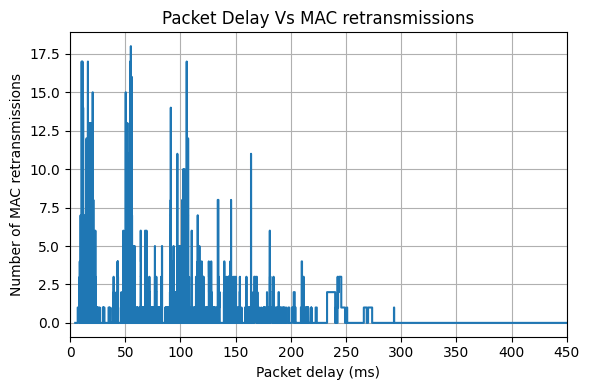

In [ ]:
# Get the no of mac retransmissions
mretx = df['mretx'].tolist()

# plot delay distribution over the number of mac retransmissions
plt.figure(figsize=(6, 4))
plt.step(delays, mretx, where='post')       # survival curve style
plt.xlim(0, 450)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Number of MAC retransmissions')
plt.title('Packet Delay Vs MAC retransmissions')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

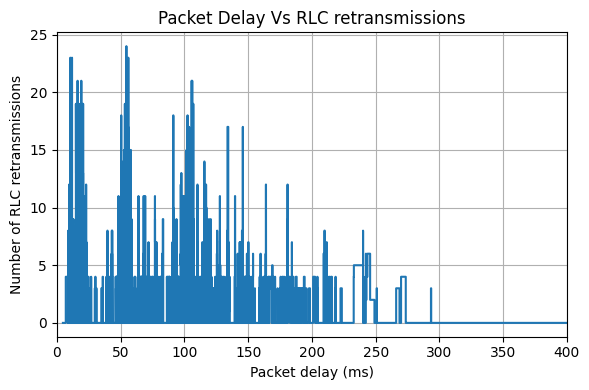

In [ ]:
# Get the no of rlc retransmissions
rlcRetx = df['rfailed'].tolist()

# plot delay distribution over the number of rlc retransmissions
plt.figure(figsize=(6, 4))
plt.step(delays, rlcRetx, where='post')       # survival curve style
plt.xlim(0, 400)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Number of RLC retransmissions')
plt.title('Packet Delay Vs RLC retransmissions')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

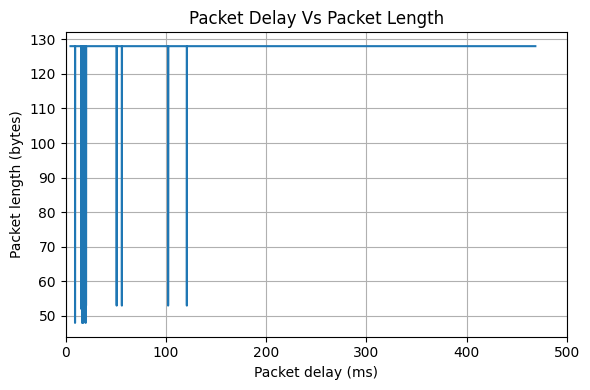

In [ ]:
# Get the packet length
pktLen = df['len'].tolist()

# plot delay distribution over the packet length
plt.figure(figsize=(6, 4))
plt.step(delays, pktLen, where='post')       # survival curve style
plt.xlim(0, 500)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Packet length (bytes)')
plt.title('Packet Delay Vs Packet Length')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()